# Supply Chain Shipment Mode Prediction

## Abstract

This project develops a machine learning model to predict the shipment mode (Air, Truck, Air Charter, Ocean) for supply chain deliveries using a dataset with features like country, product details, and delivery metrics. Implemented in Python using TensorFlow, the model achieves an accuracy of 87.93% on the test set. 

The project includes data preprocessing, feature engineering, neural network training, and performance evaluation with a confusion matrix and classification report.



In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

In [3]:
for dirname, _, filenames in os.walk("input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

input\Delivery_Dataset.csv


In [5]:
data = pd.read_csv("input/Delivery_Dataset.csv")

In [6]:
data.head(7)

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN
5,23,112-NG-T01,Pre-PQ Process,SCMS-87,ASN-57,Nigeria,PMO - US,Direct Drop,EXW,Air,...,240,416,2225.6,5.35,0.02,"Aurobindo Unit III, India",Yes,504,5920.42,NaN
6,44,110-ZM-T01,Pre-PQ Process,SCMS-139,ASN-130,Zambia,PMO - US,Direct Drop,DDU,Air,...,90,135,4374.0,32.40,0.36,MSD South Granville Australia,Yes,328,Freight Included in Commodity Cost,NaN


In [7]:
def preprocess_inputs(df, label_mapping):
    df = df.copy()

    # Dropping ID Column Because That Is Unique For Each Shipment & Doesn't Serve Any Process
    df = df.drop("ID", axis=1)

    # Dropping Missing Values in Target Rows Of [Shipment Mode] Column as that is our target column and we don't to do prediction on fabricated dat

    missing_target_rows = df[df["Shipment Mode"].isna()].index
    df = df.drop(missing_target_rows, axis=0).reset_index(drop=True)

    # Filling Missing values
    df["Dosage"] = df["Dosage"].fillna(df["Dosage"].mode()[0])
    df["Line Item Insurance (USD)"] = df["Line Item Insurance (USD)"].fillna(
        df["Line Item Insurance (USD)"].mean()
    )

    # Drop Date Column With Too Many Missing Values
    df = df.drop(["PQ First Sent to Client Date", "PO Sent to Vendor Date"], axis=1)

    # Extract Date Features
    for column in [
        "Scheduled Delivery Date",
        "Delivered to Client Date",
        "Delivery Recorded Date",
    ]:
        df[column] = pd.to_datetime(df[column])
        df[column + " Year"] = df[column].apply(lambda x: x.year)
        df[column + " Month"] = df[column].apply(lambda x: x.month)
        df[column + " Day"] = df[column].apply(lambda x: x.day)
        df = df.drop(column, axis=1)

    # Drop Numeric Columns for too many missing values
    df = df.drop(["Weight (Kilograms)", "Freight Cost (USD)"], axis=1)

    # Drop High Cardinality Columns
    df = df.drop(["PQ #", "PO / SO #", "ASN/DN #"], axis=1)

    # Binary Encoding
    df["Fulfill Via"] = df["Fulfill Via"].replace({"Direct Drop": 0, "From RDC": 1})
    df["First Line Designation"] = df["First Line Designation"].replace(
        {"No": 0, "Yes": 1}
    )

    # One-Hot Encoding
    for column in df.select_dtypes("object").columns.drop("Shipment Mode"):
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)

    # Splitting The DataFrame into X and y
    y = df["Shipment Mode"]
    X = df.drop("Shipment Mode", axis=1)

    # Encoding The Labels In Shipment Mode
    y = y.replace(label_mapping)

    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, shuffle=True, random_state=1
    )

    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(
        scaler.transform(X_train), index=X_train.index, columns=X_train.columns
    )
    X_test = pd.DataFrame(
        scaler.transform(X_test), index=X_test.index, columns=X_test.columns
    )

    return X_train, X_test, y_train, y_test

In [8]:
LABEL_MAPPING = {"Air": 0, "Truck": 1, "Air Charter": 2, "Ocean": 3}

X_train, X_test, y_train, y_test = preprocess_inputs(data, label_mapping=LABEL_MAPPING)

C:\Users\31234\AppData\Local\Temp\ipykernel_36268\1814702376.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[column] = pd.to_datetime(df[column])
C:\Users\31234\AppData\Local\Temp\ipykernel_36268\1814702376.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[column] = pd.to_datetime(df[column])
C:\Users\31234\AppData\Local\Temp\ipykernel_36268\1814702376.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[column] = pd.to_datetime(df[column])


In [9]:
X_train.shape

(6974, 771)

In [10]:
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [11]:
import tensorflow as tf

inputs = tf.keras.Input(shape=(771,))
x = tf.keras.layers.Dense(128, activation="relu")(inputs)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        )
    ],
)

Epoch 1/100
175/175 [==============================] - 1s 2ms/step - loss: 0.4539 - accuracy: 0.8234 - val_loss: 0.3229 - val_accuracy: 0.8738
Epoch 2/100
175/175 [==============================] - 0s 2ms/step - loss: 0.2380 - accuracy: 0.9009 - val_loss: 0.2861 - val_accuracy: 0.8832
Epoch 3/100
175/175 [==============================] - 0s 2ms/step - loss: 0.2018 - accuracy: 0.9113 - val_loss: 0.2828 - val_accuracy: 0.8774
Epoch 4/100
175/175 [==============================] - 0s 2ms/step - loss: 0.1813 - accuracy: 0.9199 - val_loss: 0.2821 - val_accuracy: 0.8918
Epoch 5/100
175/175 [==============================] - 0s 2ms/step - loss: 0.1630 - accuracy: 0.9283 - val_loss: 0.2900 - val_accuracy: 0.8896
Epoch 6/100
175/175 [==============================] - 0s 1ms/step - loss: 0.1526 - accuracy: 0.9330 - val_loss: 0.3118 - val_accuracy: 0.8853
Epoch 7/100
175/175 [==============================] - 0s 2ms/step - loss: 0.1444 - accuracy: 0.9360 - val_loss: 0.2998 - val_accuracy: 0.8961

In [13]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred, labels=list(LABEL_MAPPING.values()))
clr = classification_report(
    y_test,
    y_pred,
    labels=list(LABEL_MAPPING.values()),
    target_names=list(LABEL_MAPPING.keys()),
)

print(
    "Test Set Accuracy: {:.2f}%".format(
        model.evaluate(X_test, y_test, verbose=0)[1] * 100
    )
)

94/94 [==============================] - 0s 785us/step
Test Set Accuracy: 87.93%


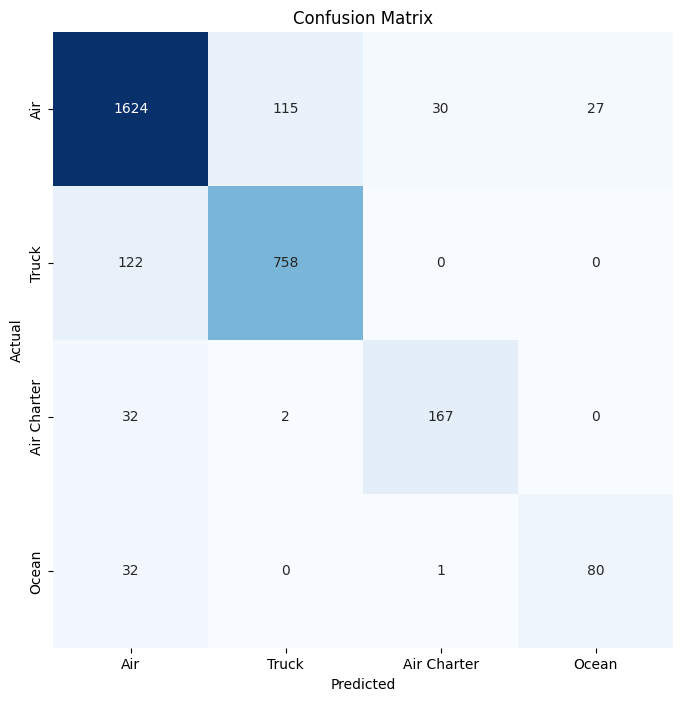

Classification Report:
----------------------
               precision    recall  f1-score   support

         Air       0.90      0.90      0.90      1796
       Truck       0.87      0.86      0.86       880
 Air Charter       0.84      0.83      0.84       201
       Ocean       0.75      0.71      0.73       113

    accuracy                           0.88      2990
   macro avg       0.84      0.83      0.83      2990
weighted avg       0.88      0.88      0.88      2990



In [15]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="g", vmin=0, cmap="Blues", cbar=False)
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=list(LABEL_MAPPING.keys()))
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=list(LABEL_MAPPING.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)